In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchprofile
from Dataloader import prepare_data_loader
from obspy import read
from scipy import signal
from matplotlib import cm
from datetime import timedelta
from Models import Encoder, Classifier
import os

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
training_data_dir = './data/lunar/training/data/S12_GradeA/'
training_labels_file = './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'

train_loader = prepare_data_loader(overlap=0.25,
                                  window_length=1,
                                  decimation_factor=3,
                                  spect_nfft=128,
                                  spect_nperseg=128,
                                  batch_size=128,
                                  data_dir=training_data_dir,
                                  labels_file_path=training_labels_file)

In [4]:
height, width = train_loader.dataset.tensors[0].shape[1:]

In [ ]:
hidden_size = 100
classifier = Classifier(hidden_size).to(device)
encoder = Encoder(hidden_size).to(device)
encoder.load_state_dict(torch.load('./models/encoder.pth', weights_only=False))

In [ ]:
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-5)
criterion = nn.BCELoss()

num_epochs = 100
all_losses = []
classifier.train()
for epoch in range(num_epochs):
    for x, y in train_loader:
        x = x.reshape(-1, 1, height, width).to(device)
        y = y.float().to(device)
        embedding = encoder(x)
        embedding = embedding.view(embedding.size(0), -1)
        preds = classifier(embedding)
        preds = preds.view(-1)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch [{epoch + 1}/{num_epochs}], loss: {loss.item()}')
    all_losses.append(loss.item())

# torch.save(classifier, './models/classifier.pth')
plt.plot(all_losses)
plt.yscale('log')
plt.show()

In [ ]:
state_dict = torch.load('./models/classifier.pth', map_location=device, weights_only=False)
classifier.load_state_dict(state_dict.state_dict())

In [ ]:
dummy_input = torch.randn(1, 1, height, width).to(device)

encoder_flops = torchprofile.profile_macs(encoder, dummy_input)
embedding = encoder(dummy_input)
embedding = embedding.view(embedding.size(0), -1)
classifier_flops = torchprofile.profile_macs(classifier, embedding)
total_flops = encoder_flops + classifier_flops

print(f'Encoder: {encoder_flops} FLOPS')
print(f'Classifier: {classifier_flops} FLOPS')
print(f'Total: {total_flops} FLOPS')

In [ ]:
def calculate_memory_requirements(model, input_size):
    num_params = sum(p.numel() for p in model.parameters())
    param_memory = num_params * 4  # 32-bit (4 bytes) precision
    dummy_input = torch.randn(input_size).to(device)
    activations = []
    def hook(module, input, output):
        activations.append(output)
    hooks = []
    for layer in model.children():
        hooks.append(layer.register_forward_hook(hook))
    model(dummy_input)
    activation_memory = sum(a.numel() * 4 for a in activations)
    gradient_memory = activation_memory
    total_memory = param_memory + activation_memory + gradient_memory
    total_memory_mb = total_memory / (1024 ** 2)
    for hook in hooks:
        hook.remove()
    return total_memory_mb

input_size = (1, 1, height, width)
encoder_memory = calculate_memory_requirements(encoder, input_size)
classifier_memory = calculate_memory_requirements(classifier, (1, 100))

total_memory_mb = encoder_memory + classifier_memory
print(f'Total RAM required: {total_memory_mb:.2f} MB')

In [9]:
thr_loader = torch.utils.data.DataLoader(train_loader.dataset.tensors[0], batch_size=1)
classifier.eval()
preds_list = []
with torch.no_grad():
    for x in thr_loader:
        x = x.reshape(-1, 1, height, width).to(device)
        embedding = encoder(x)
        embedding = embedding.view(embedding.size(0), -1)
        preds = classifier(embedding)
        preds = preds.view(-1)
        preds_list.append(preds.item())
preds_list = torch.tensor(preds_list)

In [ ]:
max_fscore = 0
for thr in range(1, 100):
    threshold = thr / 100
    preds = preds_list > threshold
    true_positives = (preds & train_loader.dataset.tensors[1].bool()).sum().item()
    false_positives = (preds & ~train_loader.dataset.tensors[1].bool()).sum().item()
    false_negatives = (~preds & train_loader.dataset.tensors[1].bool()).sum().item()
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    fscore = 2 * precision * recall / (precision + recall)
    if max_fscore < fscore:
        max_fscore = fscore
        best_thr = threshold
print(f'Threshold: {best_thr}, Fscore: {max_fscore:.2f}')

In [ ]:
test_data_dir = './data/lunar/test/data/S12_GradeB/'

spctrs, enc_dates = prepare_data_loader(overlap=0.25,
                                  window_length=1,
                                  decimation_factor=3,
                                  spect_nfft=128,
                                  spect_nperseg=128,
                                  batch_size=128,
                                  data_dir=test_data_dir,
                                  one_file=True)

In [12]:
testset = torch.utils.data.TensorDataset(torch.tensor(spctrs))
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

In [13]:
dates = [date[0].strftime('%Y-%m-%d %H:%M:%S') for date in enc_dates]

In [14]:
date_to_pred, date_to_spc = {}, {}
classifier.eval()
with torch.no_grad():
    for i, spc in enumerate(test_loader):
        x = spc[0].float().reshape(-1, 1, height, width).to(device)
        embedding = encoder(x)
        embedding = embedding.view(embedding.size(0), -1)
        preds = classifier(embedding)
        date_to_pred[dates[i]] = preds.item() > best_thr
        date_to_spc[dates[i]] = spc[0]

In [71]:
num_file = 5
data_directory = './data/lunar/test/data/S12_GradeB/'
# data_directory = './data/lunar/test/data/S15_GradeA/'
# data_directory = './data/lunar/test/data/S15_GradeB/'
for i, file in enumerate(os.listdir(data_directory)):
    if file.endswith('.mseed'):
        if i // 2 == num_file:
            print(file)
            mseed_file = f'{data_directory}{file}'
            st = read(mseed_file)
            break

xa.s12.00.mhz.1970-03-30HR00_evid00020.mseed


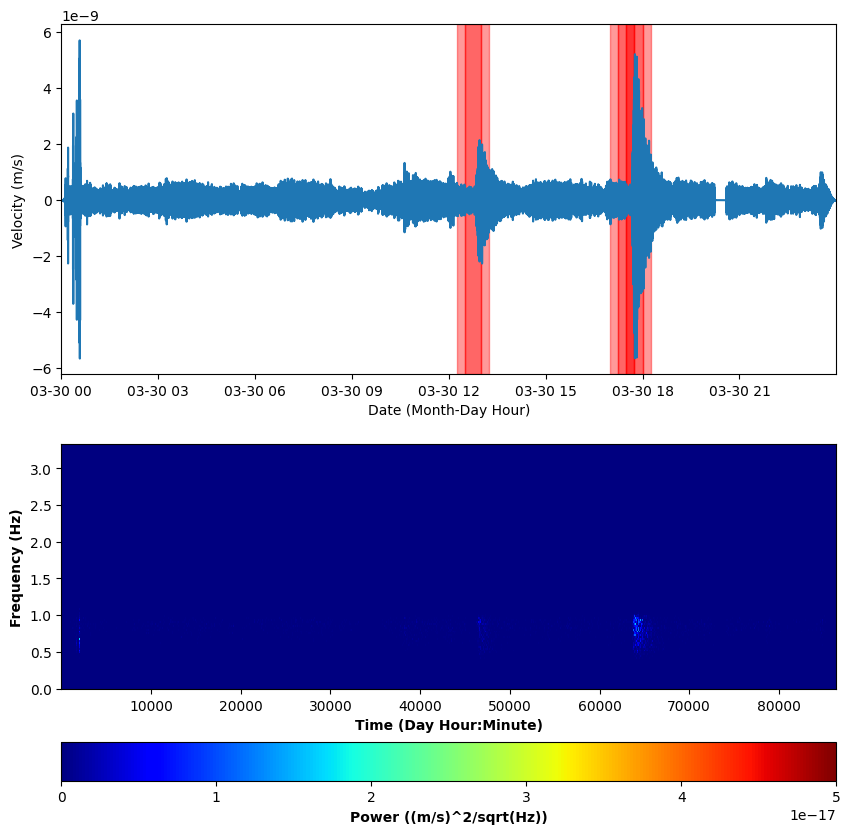

In [83]:
st_filt = st.copy()
st_filt.filter('bandpass', freqmin=0.5, freqmax=1.0)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr = st.traces[0].copy()
tr_times = tr.times()

starttime = tr.stats.starttime.datetime
endtime = starttime + timedelta(seconds=tr_times[-1])
time_diff = int((endtime - starttime).total_seconds() / 3600)
tr_data_filt = tr_filt.data
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)
fig = plt.figure(figsize=(10, 10))
 
ax = plt.subplot(2, 1, 1)
ax.plot(tr_times_filt, tr_data_filt)
ax.set_xlim([min(tr_times_filt), max(tr_times_filt)])
ax.set_xticks([min(tr_times_filt) + i * 3600 for i in range(0, time_diff + 1, 3)])
ax.set_xticklabels([(starttime + timedelta(hours=i)).strftime('%m-%d %H') for i in range(0, time_diff + 1, 3)])

filterer = {}
for i in range(4 * time_diff + 4):
    time = starttime + timedelta(minutes=15*i)
    filterer[(time - starttime).total_seconds()] = 0

for i in range(4 * time_diff + 1):
    time = starttime + timedelta(minutes=15*i)
    if date_to_pred.get(time.strftime('%Y-%m-%d %H:%M:%S'), False):
        # print(time.strftime('%Y-%m-%d %H:%M:%S'))
        t_label = (time - starttime).total_seconds()
        for j in range(4):
            filterer[t_label + 900 * j] += 1
i = 0
while i < 4 * time_diff + 1:
    time = starttime + timedelta(minutes=15*i)
    t_label = (time - starttime).total_seconds()
    length = 1
    if filterer[t_label] > 1:
        while filterer[t_label + length*900] > 1:
            if filterer[t_label + length*900] != filterer[t_label]:
                break
            length += 1
        ax.axvspan(t_label, t_label+length*900, color='red', alpha=0.2*filterer[t_label])
    i += length

ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Date (Month-Day Hour)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

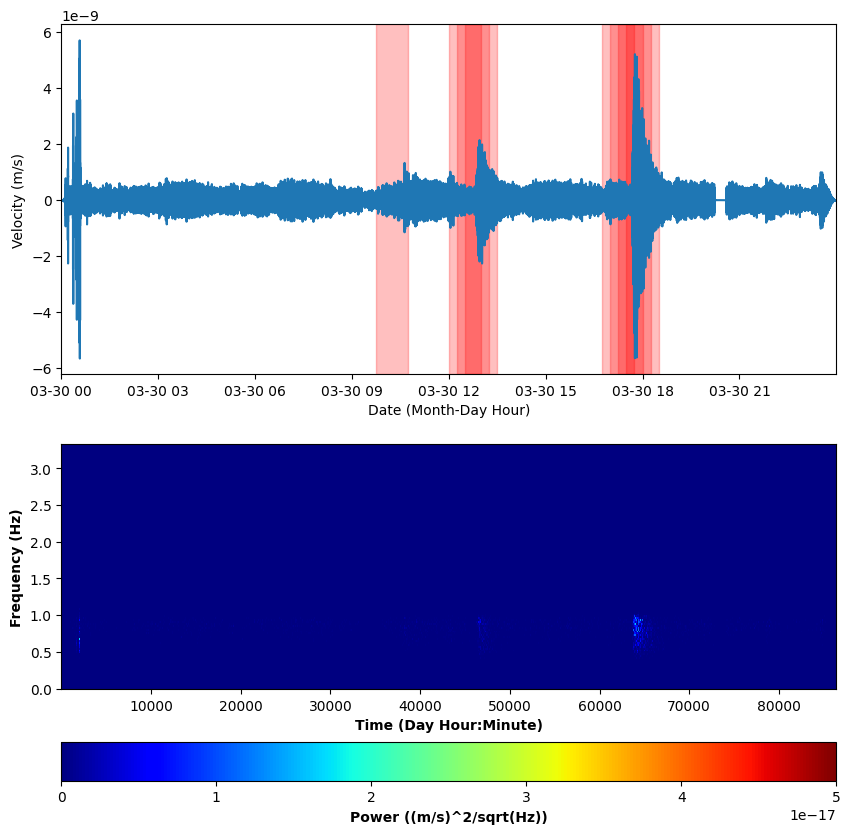

In [80]:
st_filt = st.copy()
st_filt.filter('bandpass', freqmin=0.5, freqmax=1.0)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr = st.traces[0].copy()
tr_times = tr.times()

starttime = tr.stats.starttime.datetime
endtime = starttime + timedelta(seconds=tr_times[-1])
time_diff = int((endtime - starttime).total_seconds() / 3600)
tr_data_filt = tr_filt.data
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)
fig = plt.figure(figsize=(10, 10))
 
ax = plt.subplot(2, 1, 1)
ax.plot(tr_times_filt, tr_data_filt)
ax.set_xlim([min(tr_times_filt), max(tr_times_filt)])
ax.set_xticks([min(tr_times_filt) + i * 3600 for i in range(0, time_diff + 1, 3)])
ax.set_xticklabels([(starttime + timedelta(hours=i)).strftime('%m-%d %H') for i in range(0, time_diff + 1, 3)])

filterer = {}
for i in range(4 * time_diff + 4):
    time = starttime + timedelta(minutes=15*i)
    filterer[(time - starttime).total_seconds()] = 0

for i in range(4 * time_diff + 1):
    time = starttime + timedelta(minutes=15*i)
    if date_to_pred.get(time.strftime('%Y-%m-%d %H:%M:%S'), False):
        # print(time.strftime('%Y-%m-%d %H:%M:%S'))
        t_label = (time - starttime).total_seconds()
        for j in range(min(4, 4 * time_diff + 1 - i)):
            filterer[t_label + 900 * j] += 1
        ax.axvspan(t_label, t_label+3600, color='red', alpha=0.25)

ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Date (Month-Day Hour)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')